based on 
https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo
and
http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

I just want to predict if a stock will rise based on previous information

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
from subprocess import check_output
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

In [2]:
prices_dataset =  pd.read_csv('./input/prices.csv', header=0)
prices_dataset

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


In [3]:
# prices_dataset의 symbol column이 YHOO 인 row를 data frame yahoo에 저장
yahoo = prices_dataset[prices_dataset['symbol']=='YHOO']
yahoo['close']

713       17.100000
1181      17.230000
1649      17.170000
2117      16.700001
2585      16.700001
            ...    
849257    38.660000
849757    38.919998
850257    38.730000
850757    38.639999
851257    38.669998
Name: close, Length: 1762, dtype: float64

# Step1. 데이터 전처리

In [4]:
# closs column의 값들의 자료형을 float32로 변경해 yahoo_stock_prices에 저장
yahoo_stock_prices = yahoo['close'].values.astype('float32') 

# yahoo_stock_prices를 시각화하기 위해 (1762,1)(1차원)으로 reshape 
yahoo_stock_prices = yahoo_stock_prices.reshape(1762, 1)

In [5]:
yahoo_stock_prices_copy = yahoo_stock_prices.copy()

scaler = MinMaxScaler(feature_range=(0, 1)) 
# (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# Min-Max를 통해 0~1사이로 값을 변형

yahoo_stock_prices = scaler.fit_transform(yahoo_stock_prices)
# yahoo_stock_prices를 0~1 사이로 변경

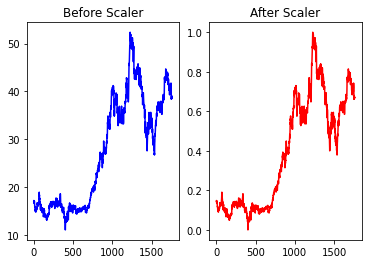

In [6]:
plt.subplot(1,2,1)
plt.plot(yahoo_stock_prices_copy,'b')
plt.title("Before Scaler")

plt.subplot(1,2,2)
plt.plot(yahoo_stock_prices,'r')
plt.title("After Scaler")
plt.show()

In [7]:
# 80%의 시퀀스(시작부터 80%시점까지)를 Training Set으로 20%의 시퀀스(80%시점부터 끝까지)를 Test Set으로 사용
train_size = int(len(yahoo_stock_prices) * 0.80)
test_size = len(yahoo_stock_prices) - train_size
train, test = yahoo_stock_prices[0:train_size,:], yahoo_stock_prices[train_size:len(yahoo_stock_prices),:]

train_ratio = round(len(train)/len(yahoo_stock_prices),3)
test_ratio = round(len(test)/len(yahoo_stock_prices),3)

print(f"Train set 비율 : {train_ratio}, Test set 비율 : {test_ratio}")

Train set 비율 : 0.8, Test set 비율 : 0.2


In [8]:
len(train)

1409

In [9]:
# convert an array of values into a dataset matrix
# t 시점에서의 데이터를 X, t+1 시점에서의 데이터를 Y로 구성하는 함수
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# create_dataset 함수를 활용해 t 시점에서의 데이터 X, t+1 시점에서의 데이터 Y 생성
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# 1차원 배열 X를 (X의 샘플수(row 수), time_step 수, 학습에 사용되는 feature 수(column 수))로 reshape → LSTM 입력을 위해
# t시점의 가격을 통해 t+1시점의 가격을 예측하므로 time_step = 1
# yahoo_stock_prices의 column 중 close column만 사용하므로 feature 수는 1
samples = trainX.shape[0]
test_samples = testX.shape[0]
time_step = 1
features = 1

trainX = np.reshape(trainX, (samples, time_step, features)) 
testX = np.reshape(testX, (test_samples, time_step, features))

# Step 2. 모델 빌드

In [12]:
model = Sequential()

# 모델 input shape를 (batch_size, time_step, features)로 지정
# 해당 LSTM Layer를 통해 하나의 sample당 50개의 Unit을 출력
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, features)))
model.add(Dropout(0.2))

# 해당 LSTM Layer를 통해 하나의 sample당 100개의 Unit을 출력
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

# t시점에 대해 t+1 시점의 가격 1개를 예측해야하므로 Dense=1로 지정
# 즉, 출력이 1개여야 하므로 해당 Dense Layer의 출력은 1개여야함
model.add(Dense(1))
model.add(Activation('linear'))

# 학습시 사용될 Loss 및 Optimizer 정의
model.compile(loss='mse', optimizer='rmsprop')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
____________________________________________________

In [14]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=10,
    validation_split=0.05)

Epoch 1/10
11/11 [==============================] - 4s 86ms/step - loss: 0.1418 - val_loss: 0.2864
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0829 - val_loss: 0.1375
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0405 - val_loss: 0.0550
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0275 - val_loss: 0.0338
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0135
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 3.9435e-04
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 3.7901e-04
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 10/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 3.6721e-

In [15]:
predicted_price = model.predict(testX)

In [16]:
def plot_results_multiple(predicted_data, true_data):
    plt.subplot(1,2,1)
    plt.title("Actual price")
    plt.plot(scaler.inverse_transform(true_data.reshape(-1,1)))
    
    plt.subplot(1,2,2)
    plt.title("Predicted price")
    plt.plot(scaler.inverse_transform(np.array(predicted_data)), 'r')
    plt.show()
    

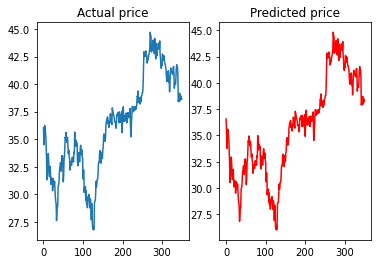

In [17]:
plot_results_multiple(predicted_price, testY)

## 5일 동안의 가격을 예측

In [23]:
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []      
        
        predicted_price = model.predict(curr_frame[newaxis,:,:])
        predicted.append(predicted_price[0][0])
        
        curr_frame = predicted_price
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[3], predict_length)

In [26]:
predicted_price = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
true_price = scaler.inverse_transform(testY[3:3+predict_length].reshape(-1,1))

In [27]:
for i,[pred, true] in enumerate(zip(predicted_price, true_price)):
    print(f"{i+1}일 후, 실제 주식 가격 : {true}, 예측 주식 가격 : {pred}")

1일 후, 실제 주식 가격 : [36.24], 예측 주식 가격 : [35.274593]
2일 후, 실제 주식 가격 : [36.1], 예측 주식 가격 : [34.588444]
3일 후, 실제 주식 가격 : [35.69], 예측 주식 가격 : [33.874058]
4일 후, 실제 주식 가격 : [35.19], 예측 주식 가격 : [33.13459]
5일 후, 실제 주식 가격 : [34.1], 예측 주식 가격 : [32.373817]
